In this notebook, stock price prediction based on LSTM and timeseries data is demonstrated.

Based on the model predictions, data is also extrapolated considering the previously predicted values.

Referred articles :
https://medium.com/@matthew1992/forecasting-stock-with-different-models-arima-lstm-fourier-ef096885cf75
https://medium.com/@redeaddiscolll/stock-market-time-series-lstm-failure-56089ce3c0b8
https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.initializers import HeNormal
from keras.layers import Dropout
from keras.layers import Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
import math
from sklearn.metrics import mean_squared_error
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
!pip install pandas_ta
import pandas_ta as ta
import datetime
import seaborn as sns
from numpy.random import seed
seed(0)
from tqdm import tqdm
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=53595ab54030db222f98310704199b1dd6c6aa35520f1341608d060f4c039cbd
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## Featurizing with technical indicators
def get_technical_indicators(dataset): #function to generate feature technical indicators


    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    dataset['ma50'] = dataset['Close'].rolling(window = 50).mean()

    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['50ema'] = dataset['Close'].ewm(span=50).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)


    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    dataset['momentum'] = (dataset['Close']/100)-1

    return dataset

In [ ]:
def extrapolation_automation(stock_list):
  for ticker in stock_list:
    # get stock data
    start=f"{datetime.datetime.now() - datetime.timedelta(days=950):%Y-%m-%d}" # we are going to train lstm on last 2 yr 2 months of data
    df = pdr.get_data_yahoo(str(ticker+".NS"), start=start)
    df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True) # as only close value will be considered for prediction
    df=df.dropna()
    df[df.isna().any(axis=1)]

    # Lets build Technical features
    ignore_first_points=51 # as we are considering the 50 moving averages
    df_TI=df.copy()
    df_TI=get_technical_indicators(df_TI)
    # Also as first 51 rows has Nan values lets ignore these rows
    df_TI=df_TI.iloc[ignore_first_points:]
    print('Nan values in the dataframe are',len(df_TI[df_TI.isna().any(axis=1)]))
    print('Start date of dataframe is ',df_TI.index[0])
    print('End date of dataframe is ',df_TI.index[-1])
    print('Featurization is complete.')
    print('-'*50)

    # Train test split and time series data preperation
    # Define the parameters of number of features and look back period for time series generator
    look_back = 30
    n_features=12
    test_pred_days=3
    # Lets validate the predictions on the last two months of data
    test_prediction_start_date=f"{datetime.datetime.now() - datetime.timedelta(days=test_pred_days):%Y-%m-%d}"
    # train / test split
    train_data = df_TI.query('Date <  @test_prediction_start_date').reset_index(drop = False)
    test_data_actual  = df_TI.query('Date >= @test_prediction_start_date').reset_index(drop = False)

    # Lets add additinal samples = look_back from train_data at test top
    test_add=train_data[-look_back:]
    test_data = pd.concat([test_add,test_data_actual.loc[:]]).reset_index(drop=True)

    X_train = train_data.drop(['Date','Close'],axis=1)
    y_train = train_data['Close']
    X_test = test_data.drop(['Date','Close'],axis=1)
    y_test = test_data['Close']
    # Lets reshape the outputs to match with time series generator requirement
    y_train=y_train.values.reshape((len(y_train),1))
    y_test=y_test.values.reshape((len(y_test),1))

    # Min max scaling of X train and test data
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    print('Shape of X_train is ',X_train.shape)
    print('Shape of y_train is ',y_train.shape)
    print('Shape of X_test is ',X_test.shape)
    print('Shape of y_test is ',y_test.shape)
    print('Min max scaling of data is complete')

    # Time series generator
    train_generator = TimeseriesGenerator(X_train, y_train,
                                          length        = look_back,
                                          sampling_rate = 1,
                                          stride        = 1,
                                          batch_size    = 1)
    test_generator = TimeseriesGenerator(X_test, y_test,
                                          length        = look_back,
                                          sampling_rate = 1,
                                          stride        = 1,
                                          batch_size    = 1)

    print('Data processing, train test split and time series data generation is completed.')
    print('-'*50)

    print('Starting with model training')
    # Lets build a model for prediction

    initializer = HeNormal()

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units = 20, kernel_initializer=initializer, activation='relu'))
    model.add(Dense(units = 1, kernel_initializer=initializer, activation='relu'))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
    model.fit(train_generator, epochs = 120, batch_size = 16,verbose=1)

    # Lets dump the model
    pickle_path = '/content/drive/MyDrive/Stock Predictions/DataFiles/'

    pickle_out=open(pickle_path+'LSTM_NAVINFLUOR_Model.pickle', 'wb')
    pickle.dump(model,pickle_out)
    pickle_out.close()

    print('Model training is completed')
    print('-'*50)

    # Predictions and extrapolations
    print('Lets predict and extrapolate')
    test_predictions  = model.predict(test_generator)
    train_samples=400
    y_test_extpr=[]
    # Lets extrapolate for the 30 days
    Extpr_days=30
    for i in tqdm(range(Extpr_days), desc = 'tqdm() Progress Bar'):
      lst=train_data['Close'][-train_samples:].tolist()
      # append the predicted value from second step
      if i>0:
        lst.extend(y_test_extpr)
      # Creating a dataframe from dictionary of lists
      dict = {'Close': lst}
      df_extpr = pd.DataFrame(dict)
      df_extpr=get_technical_indicators(df_extpr)
      # Last observations with lookback period
      df_extpr=df_extpr.iloc[train_samples-look_back+i:]
      df_extpr.reset_index(inplace=True)
      df_extpr.drop(columns=['index'],inplace=True)
      X_test_extpr = df_extpr.drop(['Close'],axis=1)
      X_test_extpr=scaler.transform(X_test_extpr)
      X_test_extpr=X_test_extpr.reshape((1,look_back, n_features))
      predicted_value = model.predict(X_test_extpr)[0]
      y_test_extpr.append(predicted_value[0])

    print('Computed extrapolations')

    test_dates=test_data['Date'][-test_pred_days-1:].tolist()
    extrapolated_dates=[d.strftime('%Y-%m-%d') for d in pd.date_range(f"{datetime.datetime.now()+ datetime.timedelta(days=1) :%Y-%m-%d}",
                  f"{datetime.datetime.now() + datetime.timedelta(days=(Extpr_days-test_pred_days-1)):%Y-%m-%d}")]
    test_dates.extend(extrapolated_dates)

    extpr_df=pd.DataFrame({'Date':test_dates})
    print('Created dates metrics')

    pickle_out=open(pickle_path+'extpr_df.pickle', 'wb')
    pickle.dump(extpr_df,pickle_out)
    pickle_out.close()

    pickle_out=open(pickle_path+'y_test_extpr.pickle', 'wb')
    pickle.dump(y_test_extpr,pickle_out)
    pickle_out.close()

    extpr_df['Extrapolation']=y_test_extpr
    print('Computed extrapolation dataframe')

    # Plotting and saving the generated plot
    plt.figure(figsize=(12,4))
    plt.plot(test_data.Date[look_back:], test_data['Close'][look_back:], c='orange',label='true values')
    plt.plot(test_data.Date[look_back:],test_predictions.reshape(-1).tolist(), lw=4, c='r',linestyle = '-', label='predictions')
    plt.plot(extpr_df.Date,extpr_df['Extrapolation'], lw=2, c='b',linestyle = '-', label='extrapolations')
    # plt.legend(loc="lower left")
    plt.legend()
    plt.xlabel("date", fontsize=10)
    plt.ylabel("Close price (Rs) (rescaled)", fontsize=10)
    plt.title("Closing value", fontsize=12)
    images_dir = '/content/drive/MyDrive/Stock Predictions/LSTMPredictions/'+ticker
    plt.savefig(f"{images_dir}.JPG")
    plt.show()

[*********************100%%**********************]  1 of 1 completed
Nan values in the dataframe are 0
Start date of dataframe is  2021-08-04 00:00:00
End date of dataframe is  2023-12-29 00:00:00
Featurization is complete.
--------------------------------------------------
Shape of X_train is  (593, 12)
Shape of y_train is  (593, 1)
Shape of X_test is  (33, 12)
Shape of y_test is  (33, 1)
Min max scaling of data is complete
Data processing, train test split and time series data generation is completed.
--------------------------------------------------
Starting with model training
Epoch 1/120
563/563 [==============================] - 18s 25ms/step - loss: 4110947.2500 - mean_absolute_error: 1583.6759
Epoch 2/120
563/563 [==============================] - 14s 25ms/step - loss: 673558.3125 - mean_absolute_error: 565.4465
Epoch 3/120
563/563 [==============================] - 14s 25ms/step - loss: 103363.1797 - mean_absolute_error: 241.4943
Epoch 4/120
563/563 [=========================

tqdm() Progress Bar:   0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 1s 793ms/step


tqdm() Progress Bar:   3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  10%|█         | 3/30 [00:01<00:08,  3.33it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  17%|█▋        | 5/30 [00:01<00:04,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


tqdm() Progress Bar:  20%|██        | 6/30 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  27%|██▋       | 8/30 [00:01<00:02,  7.37it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  33%|███▎      | 10/30 [00:01<00:02,  8.47it/s]

1/1 [==============================] - 0s 25ms/step


tqdm() Progress Bar:  40%|████      | 12/30 [00:01<00:01,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


tqdm() Progress Bar:  47%|████▋     | 14/30 [00:02<00:01,  9.37it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  53%|█████▎    | 16/30 [00:02<00:01,  9.84it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  60%|██████    | 18/30 [00:02<00:01, 10.03it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  67%|██████▋   | 20/30 [00:02<00:00, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


tqdm() Progress Bar:  73%|███████▎  | 22/30 [00:02<00:00, 10.07it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  80%|████████  | 24/30 [00:03<00:00, 10.17it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  87%|████████▋ | 26/30 [00:03<00:00, 10.31it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  93%|█████████▎| 28/30 [00:03<00:00, 10.17it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar: 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]


Computed extrapolations
Created dates metrics
Computed extrapolation dataframe


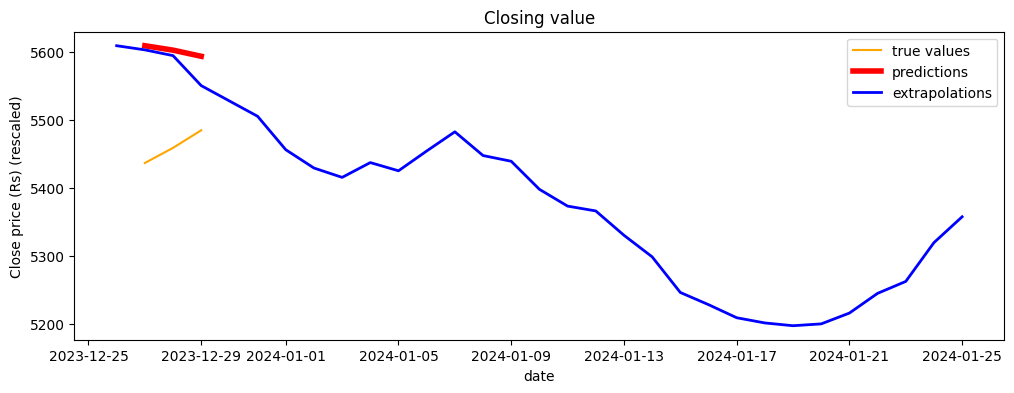

[*********************100%%**********************]  1 of 1 completed
Nan values in the dataframe are 0
Start date of dataframe is  2021-08-04 00:00:00
End date of dataframe is  2023-12-29 00:00:00
Featurization is complete.
--------------------------------------------------
Shape of X_train is  (593, 12)
Shape of y_train is  (593, 1)
Shape of X_test is  (33, 12)
Shape of y_test is  (33, 1)
Min max scaling of data is complete
Data processing, train test split and time series data generation is completed.
--------------------------------------------------
Starting with model training
Epoch 1/120
563/563 [==============================] - 19s 25ms/step - loss: 1562971.6250 - mean_absolute_error: 884.8260
Epoch 2/120
563/563 [==============================] - 14s 25ms/step - loss: 122293.7656 - mean_absolute_error: 268.1488
Epoch 3/120
563/563 [==============================] - 14s 25ms/step - loss: 75742.1328 - mean_absolute_error: 211.5491
Epoch 4/120
563/563 [===========================

tqdm() Progress Bar:   0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 1s 795ms/step


tqdm() Progress Bar:   3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


tqdm() Progress Bar:   7%|▋         | 2/30 [00:00<00:11,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  13%|█▎        | 4/30 [00:01<00:05,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  20%|██        | 6/30 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  23%|██▎       | 7/30 [00:01<00:03,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  30%|███       | 9/30 [00:01<00:02,  8.02it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  37%|███▋      | 11/30 [00:01<00:02,  8.81it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  43%|████▎     | 13/30 [00:02<00:01,  9.48it/s]

1/1 [==============================] - 0s 25ms/step


tqdm() Progress Bar:  50%|█████     | 15/30 [00:02<00:01,  9.89it/s]

1/1 [==============================] - 0s 28ms/step


tqdm() Progress Bar:  57%|█████▋    | 17/30 [00:02<00:01, 10.06it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  63%|██████▎   | 19/30 [00:02<00:01, 10.02it/s]

1/1 [==============================] - 0s 26ms/step


tqdm() Progress Bar:  70%|███████   | 21/30 [00:02<00:00,  9.93it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  77%|███████▋  | 23/30 [00:02<00:00, 10.24it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  83%|████████▎ | 25/30 [00:03<00:00, 10.41it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  90%|█████████ | 27/30 [00:03<00:00, 10.51it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  97%|█████████▋| 29/30 [00:03<00:00, 10.17it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar: 100%|██████████| 30/30 [00:03<00:00,  8.18it/s]

Computed extrapolations
Created dates metrics
Computed extrapolation dataframe


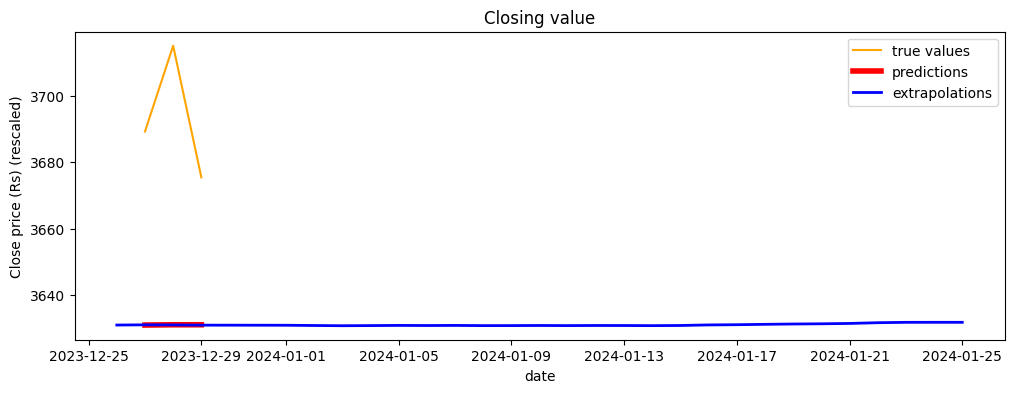

[*********************100%%**********************]  1 of 1 completed
Nan values in the dataframe are 0
Start date of dataframe is  2021-08-04 00:00:00
End date of dataframe is  2023-12-29 00:00:00
Featurization is complete.
--------------------------------------------------
Shape of X_train is  (593, 12)
Shape of y_train is  (593, 1)
Shape of X_test is  (33, 12)
Shape of y_test is  (33, 1)
Min max scaling of data is complete
Data processing, train test split and time series data generation is completed.
--------------------------------------------------
Starting with model training
Epoch 1/120
563/563 [==============================] - 18s 24ms/step - loss: 92161.9219 - mean_absolute_error: 192.6763
Epoch 2/120
563/563 [==============================] - 14s 25ms/step - loss: 4396.5908 - mean_absolute_error: 52.9389
Epoch 3/120
563/563 [==============================] - 14s 24ms/step - loss: 3189.3848 - mean_absolute_error: 44.8449
Epoch 4/120
563/563 [==============================] - 

KeyboardInterrupt: ignored

In [ ]:
stock_list=['POLYCAB', 'TITAN', 'ICICIBANK', 'FINEORG', 'DIVISLAB', 'NAVINFLUOR', 'INDIAMART', 'CARBORUNIV']
extrapolation_automation(stock_list)